Notebook created: 2018-05-23 03:37:56  
Generated from: _build_jl/jl/mccall_model.rst  

In [1]:
using PyPlot
using QuantEcon
using Distributions
using LaTeXStrings
plt = PyPlot

PyPlot

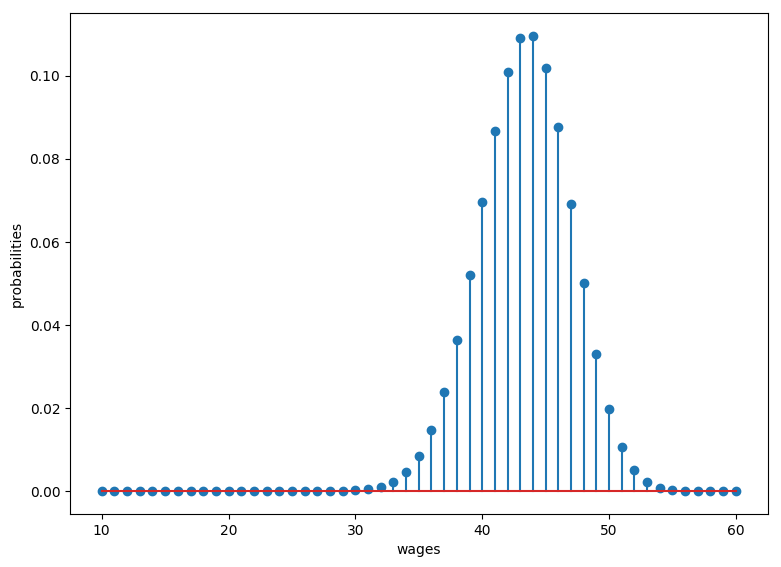

In [3]:
n, a, b = 50, 200, 100
w_min, w_max = 10, 60
const w_vals = linspace(w_min, w_max, n+1)
dist = BetaBinomial(n, a, b)
const p_vals = pdf.(dist, support(dist))

fig, ax = plt.subplots(figsize=(9, 6.5))
ax[:stem](w_vals, p_vals, label=L"$p_i$")
ax[:set_xlabel]("wages")
ax[:set_ylabel]("probabilities")

plt.show()

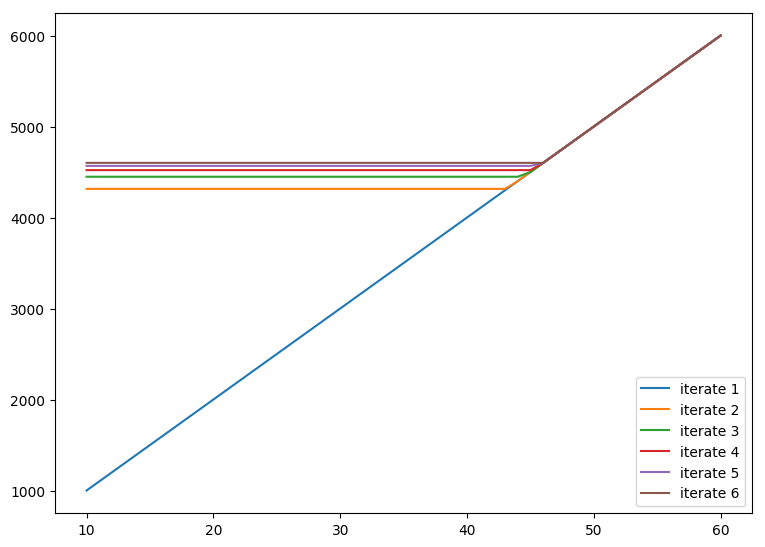

In [4]:
function plot_value_function_seq(ax,
                                 c=25,
                                 β=0.99,
                                 num_plots=6)

    v = w_vals ./ (1 - β)
    v_next = similar(v)

    for i in 1:num_plots
        ax[:plot](w_vals, v, label="iterate $i")

        # Update guess
        for (j, w) in enumerate(w_vals)
            stop_val = w / (1 - β)
            cont_val = c + β * sum(v .* p_vals)
            v_next[j] = max(stop_val, cont_val)
        end
        v[:] = v_next
    end
    ax[:legend](loc="lower right")

end

fig, ax = plt.subplots(figsize=(9, 6.5))
plot_value_function_seq(ax)
plt.show()

In [5]:
function compute_reservation_wage(c::Float64,
                                  β::Float64;
                                  max_iter::Int64=500,
                                  tol::Float64=1e-6)

# == First compute the value function == #

v = w_vals ./ (1 - β)
v_next = similar(v)
i = 0
error = tol + 1
while i < max_iter && error > tol

    for (j, w) in enumerate(w_vals)
        stop_val = w / (1 - β)
        cont_val = c + β * sum(v .* p_vals)
        v_next[j] = max(stop_val, cont_val)
    end

    error = maximum(abs.(v_next - v))
    i += 1

    v[:] = v_next  # copy contents into v
end

# == Now compute the reservation wage == #
   return (1 - β) * (c + β * sum(v .* p_vals))
end

compute_reservation_wage (generic function with 1 method)

In [6]:
c = 25.0
β = 0.99
compute_reservation_wage(c, β)

47.316499709964695

```none
47.316499709964695
```


In [7]:
grid_size = 25
R = rand((grid_size, grid_size))

c_vals = linspace(10.0, 30.0, grid_size)
β_vals = linspace(0.9, 0.99, grid_size)

for (i, c) in enumerate(c_vals)
    for (j, β) in enumerate(β_vals)
        R[i, j] = compute_reservation_wage(c, β)
    end
end

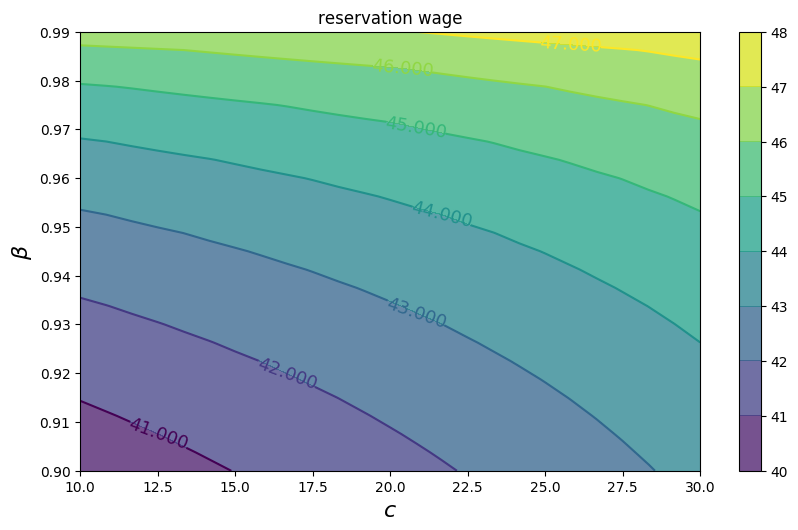

In [8]:
fig, ax = plt.subplots(figsize=(10, 5.7))

cs1 = ax[:contourf](c_vals, β_vals, R', alpha=0.75)
ctr1 = ax[:contour](c_vals, β_vals, R')

plt.clabel(ctr1, inline=1, fontsize=13)
plt.colorbar(cs1, ax=ax)

ax[:set_title]("reservation wage")
ax[:set_xlabel](L"$c$", fontsize=16)
ax[:set_ylabel](L"$β$", fontsize=16)

ax[:ticklabel_format](useOffset=false)

plt.show()

In [9]:
function compute_reservation_wage_two(c::Float64;
                                      β=0.99,
                                      max_iter=500,
                                      tol=1e-5)
    # == First compute ψ == #

    ψ = dot(w_vals, p_vals) ./ (1 - β)
    i = 0
    error = tol + 1
    while i < max_iter && error > tol

        s = max.((w_vals ./ (1 - β)), ψ)
        ψ_next = c + β * dot(s, p_vals)

        error = abs.(ψ_next - ψ)
        i += 1

        ψ = ψ_next
    end

    # == Now compute the reservation wage == #

    return (1 - β) * (c + β * ψ)
end

compute_reservation_wage_two (generic function with 1 method)

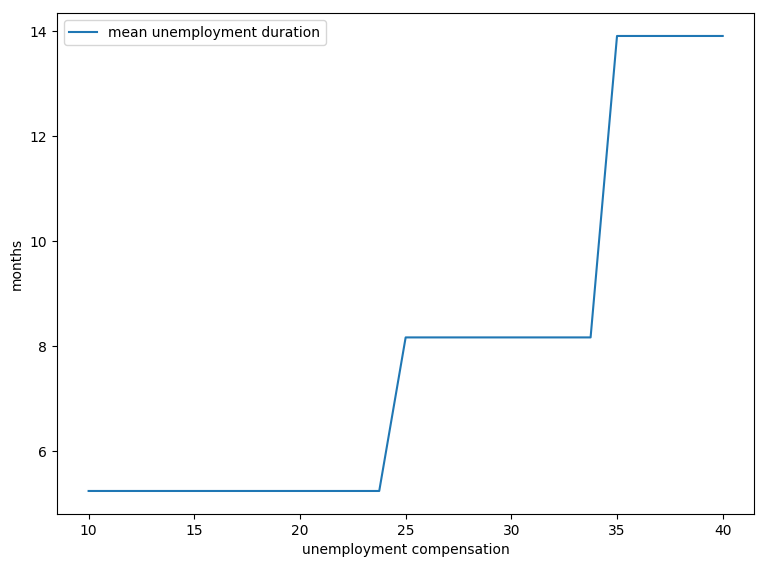

In [10]:
function compute_stopping_time(w_bar; seed=1234)

    srand(seed)
    stopping_time = 0

    t = 1
    while true
        # Generate a wage draw
        d = DiscreteRV(p_vals)
        w = w_vals[rand(d)]
        if w >= w_bar
            stopping_time = t
            break
        else
            t += 1
        end
    end
    return stopping_time
end

function compute_mean_stopping_time(w_bar, num_reps=10000)
    obs = zeros(num_reps)
    for i in 1:num_reps
        obs[i] = compute_stopping_time(w_bar, seed=i)
    end
    return mean(obs)
end


c_vals = linspace(10, 40, 25)
stop_times = similar(c_vals)

for (i, c) in enumerate(c_vals)
    w_bar = compute_reservation_wage_two(c)
    stop_times[i] = compute_mean_stopping_time(w_bar)
end

fig, ax = plt.subplots(figsize=(9, 6.5))

ax[:plot](c_vals, stop_times, label="mean unemployment duration")
ax[:set](xlabel="unemployment compensation", ylabel="months")
ax[:legend]()

plt.show()